<a name='*Challenge*'></a>
# Employee Retention

We got employee data from a few companies. We have data about all employees who joined from 2011-01-24 to 2015-12-13. For each employee, we also know if they are still at the company as of 2015-12-13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.

As said above, the goal is to predict employee retention and understand its main drivers. Specifically, you should:


1. Assume, for each company, that the headcount starts from zero on 2011-01-23. Estimate employee headcount, for each company on each day, from 2011-01-24 to 2015-12-13. That is, if by 2012-03-02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012-03-02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id
2. What are the main factors that drive employee churn? Do they make sense? Explain your findings
3. If you could add to this data set just one variable that could help explain employee churn, what would that be?

<a name='Data'></a>
# Data Description

- **employee_id:** id of the employee. Unique by employee per company
- **company_id:** company id. It is unique by company
- **dept:** employee dept
- **seniority:** number of yrs of work experience when hired
- **salary:** avg yearly salary of the employee during her tenure within the company
- **join_date:** when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13
- **quit_date:** when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

# Navigation
1. [Challenge Description](#Challenge)
2. [Data Description](#Data)
3. [Initial Exploration](#Exploration)
4. Challenge Questions
    1. [Employee Headcounts](#Headcounts)
    2. [Employee Churn](#Churn)
        - [Employment Length](#Tenure)
        - [Salary](#Salary)
        - [Hire Date](#Join) 
        - [Seniority](#Senority)
        - [Modeling](#Modeling)
    3. [Adding to the Dataset](#Adding)
5. [Conclusions](#Conclusions)


<a name='Exploration'></a>
# Initial Exploration

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/bundickm/DataMasked---Private/main/CSVs/employee_retention.csv?token=ALJ4RG3TZVYHYZDNMMRFKIDABR5NM')

print(df.shape)
df.head()

(24702, 7)


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [20]:
df['join_date'] = pd.to_datetime(df['join_date'])
df['quit_date'] = pd.to_datetime(df['quit_date'])

In [21]:
df.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


<a name='Headcounts'></a>
# Finding Company Headcounts

Finding the employee headcounts is just a quick and dirty nested loop to get the counts at any given date.

In [22]:
dates = pd.date_range(start='2011/01/24', end='2015/12/13')
employee_counts = []
company_list = []
date_list = []

for company in df['company_id'].unique():
    for i, date in enumerate(dates):
        total_joined = len(df[(df['join_date'] <= date) & 
                              (df['company_id'] == company)])
        total_quit = len(df[(df['quit_date'] <= date) & 
                            (df['company_id'] == company)])
        employee_counts.append(total_joined - total_quit)
        company_list.append(company)
        date_list.append(date)
headcount_table = pd.DataFrame({'date': date_list, 'company_id': company_list,
                                'count': employee_counts})

In [23]:
headcount_table[headcount_table['company_id'] == 1].head()

,date,company_id,count
7140,2011-01-24,1,25
7141,2011-01-25,1,27
7142,2011-01-26,1,29
7143,2011-01-27,1,29
7144,2011-01-28,1,29


<a name='Churn'></a>
# Exploring Employee Churn

<a name='Tenure'></a>
We are asked to explore empoyee churn so we first need to find employment length for each employee to see when they are leaving.

In [24]:
df['employment_length'] = (df['quit_date'] - df['join_date']).astype('timedelta64[D]')
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0


We see that employees are more likely to quit near their hire anniversary and the average employee stays less than 2 years (730 days).

In [25]:
df.groupby('company_id')['employment_length'].mean()

company_id
1     616.148886
2     628.699909
3     609.625735
4     599.630529
5     609.303154
6     603.494382
7     609.856936
8     592.962003
9     622.141777
10    612.668750
11    550.416667
12    465.166667
Name: employment_length, dtype: float64

In [26]:
df.groupby('company_id')['employment_length'].median()

company_id
1     417.0
2     430.5
3     420.0
4     415.0
5     417.0
6     413.0
7     424.0
8     403.0
9     431.0
10    410.0
11    392.0
12    354.0
Name: employment_length, dtype: float64

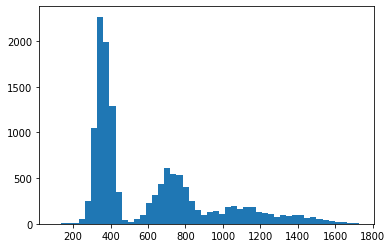

In [27]:
plt.hist(df['employment_length'].dropna(), bins=50)
plt.show()

Next we will define employees that quit early. There is a spike at the 1 year mark skewing the mean left so we'll say anyone that lasts more than a year and one month was a worthwhile hire. This year and one month time frame also lines up fairly closely with the median employment length. This will allow us to better understand the individuals leaving these companies early.

In [28]:
def early_quit(employment_length, join_date, max_date):
    if (join_date + pd.Timedelta(days=395)) > max_date:
        return np.NaN
    elif (employment_length > 395):
        return 0.0
    return 1.0

df['early_quit'] = np.vectorize(early_quit)(df['employment_length'],
                                            df['join_date'],
                                            max(df['join_date']))

In [29]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,early_quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,0.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,1.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,1.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,1.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,0.0


<a name='Salary'></a>
Companies `11` and `12` have the lowest pay and the highest `early_quit` rates. We know salary is not the only consideration for quitting early thanks to a mix of pay rates and the variation in `early_quit` but it's clear there is a lower limit for pay and that limit is dependent on company and position.

In [30]:
df.groupby('company_id')[['salary', 'early_quit']].mean()

,salary,early_quit
company_id,,
1,152167.570115,0.597323
2,155728.090952,0.597708
3,122118.588578,0.586272
4,122721.144520,0.601356
5,123348.717949,0.578909
6,119925.639040,0.606719
7,121582.516340,0.591048
8,122284.622732,0.617073
9,123905.306972,0.573351


In [31]:
salary_ranges = pd.cut(df['salary'], 30)
salary_table = pd.crosstab(salary_ranges, df['early_quit'],
                           margins=True, dropna=False)

salary_table[0.0] = salary_table[0.0] / salary_table['All']
salary_table[1.0] = salary_table[1.0] / salary_table['All']

salary_table

early_quit,0.0,1.0,All
salary,,,
"(16609.0, 30033.333]",0.294859,0.490786,1031
"(30033.333, 43066.667]",0.273923,0.476077,836
"(43066.667, 56100.0]",0.308145,0.474975,1019
"(56100.0, 69133.333]",0.322906,0.450050,1982
"(69133.333, 82166.667]",0.318857,0.474437,1819
"(82166.667, 95200.0]",0.318713,0.464327,1710
"(95200.0, 108233.333]",0.307257,0.458569,1943
"(108233.333, 121266.667]",0.326861,0.441748,1854
"(121266.667, 134300.0]",0.328096,0.461345,1591


In [32]:
print('Average Salary by Dept. (All Companies)')
print(df.groupby('dept')[['salary', 'early_quit']].mean().reset_index())

for i in range(1,13):
    print('\nCompany:', i)
    print(df[df['company_id'] == i].groupby('dept')[['salary', 'early_quit']].mean().reset_index())

Average Salary by Dept. (All Companies)
               dept         salary  early_quit
0  customer_service   82245.424837    0.596674
1      data_science  206885.893417    0.588562
2            design  137460.869565    0.581670
3          engineer  205544.548016    0.597781
4         marketing  135598.042311    0.583129
5             sales  135912.358134    0.612645

Company: 1
               dept         salary  early_quit
0  customer_service   90554.006969    0.594947
1      data_science  230938.832252    0.581882
2            design  150434.869739    0.557841
3          engineer  224193.877551    0.624797
4         marketing  151084.792627    0.582072
5             sales  150912.568306    0.613396

Company: 2
               dept         salary  early_quit
0  customer_service   92073.643411    0.612091
1      data_science  234919.014085    0.601382
2            design  154556.053812    0.532609
3          engineer  227469.240048    0.597064
4         marketing  148792.975970    0.554

<a name='Join'></a>
Looking by date we see an increase in the turnover rate year over year and that the trend holds when we look at each company individually. We'll make a new feature, `hire_year`, for later modeling.

We also see a trend for quarter, month, week, and day of week so we'll create those features as well. With quarter, month, and week we see a clear trend of starting in the third or fourth quarter being worse for employee retention. It is likely the cause is that most companies are hectic at the end of the year and employees starting in the middle of that are less likely to get the attention they need for a smooth onboarding. With day of week we see that starting on Friday is worse for retention. Again, an indicator that having a smooth uninterrupted onboarding is likely a key factor for retention.

In [33]:
print('Early Quit (All Companies)')
join_table = pd.crosstab(df['join_date'].dt.year,
                         df['early_quit'], margins=True)
join_table[0.0] = join_table[0.0] / join_table['All']
join_table[1.0] = join_table[1.0] / join_table['All']
print(join_table)

for i in range(1, 13):
    print('\nCompany:', i)
    join_table = pd.crosstab(df['join_date'].dt.year,
                            df[df['company_id'] == i]['early_quit'],
                            margins=True)
    join_table[0.0] = join_table[0.0] / join_table['All']
    join_table[1.0] = join_table[1.0] / join_table['All']
    print(join_table)

Early Quit (All Companies)
early_quit       0.0       1.0    All
join_date                            
2011        0.670053  0.329947   4725
2012        0.504912  0.495088   5191
2013        0.319281  0.680719   5005
2014        0.094448  0.905552   4341
All         0.404683  0.595317  19262

Company: 1
early_quit       0.0       1.0   All
join_date                           
2011        0.679751  0.320249  1605
2012        0.503876  0.496124  1806
2013        0.304000  0.696000  1750
2014        0.096839  0.903161  1487
All         0.402677  0.597323  6648

Company: 2
early_quit       0.0       1.0   All
join_date                           
2011        0.669173  0.330827   798
2012        0.501129  0.498871   886
2013        0.311057  0.688943   823
2014        0.090028  0.909972   722
All         0.402292  0.597708  3229

Company: 3
early_quit       0.0       1.0   All
join_date                           
2011        0.662900  0.337100   531
2012        0.514035  0.485965   570
2013 

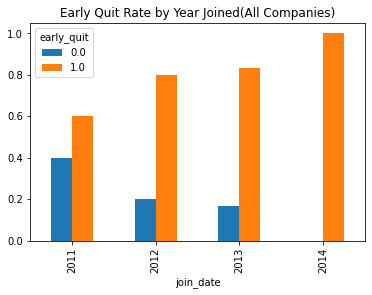

In [34]:
join_table.drop('All').drop(
    'All', axis='columns').plot.bar(
    title='Early Quit Rate by Year Joined(All Companies)');

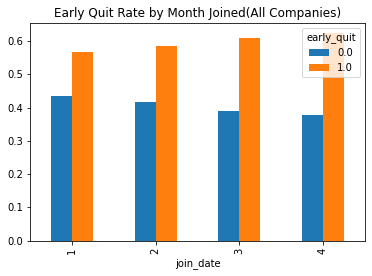

In [35]:
join_table = pd.crosstab(df['join_date'].dt.quarter,
                         df['early_quit'], margins=True)
join_table[0.0] = join_table[0.0] / join_table['All']
join_table[1.0] = join_table[1.0] / join_table['All']

join_table.drop('All').drop(
    'All', axis='columns').plot.bar(
    title='Early Quit Rate by Month Joined(All Companies)');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


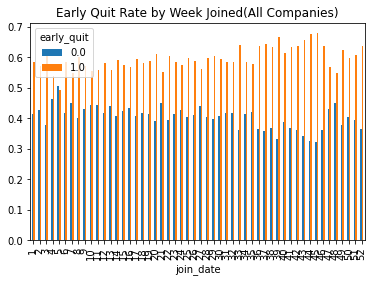

In [36]:
join_table = pd.crosstab(df['join_date'].dt.week,
                         df['early_quit'], margins=True)
join_table[0.0] = join_table[0.0] / join_table['All']
join_table[1.0] = join_table[1.0] / join_table['All']

join_table.drop('All').drop(
    'All', axis='columns').plot.bar(
    title='Early Quit Rate by Week Joined(All Companies)');

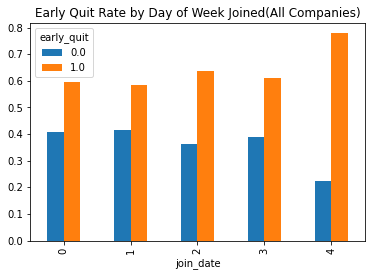

In [37]:
join_table = pd.crosstab(df['join_date'].dt.dayofweek,
                         df['early_quit'], margins=True)
join_table[0.0] = join_table[0.0] / join_table['All']
join_table[1.0] = join_table[1.0] / join_table['All']

join_table.drop('All').drop(
    'All', axis='columns').plot.bar(
    title='Early Quit Rate by Day of Week Joined(All Companies)');

In [38]:
df['hire_year'] = df['join_date'].dt.year
df['hire_quarter'] = df['join_date'].dt.quarter
df['hire_month'] = df['join_date'].dt.month
df['hire_week'] = df['join_date'].dt.week
df['hire_dayofweek'] = df['join_date'].dt.dayofweek

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


<a name='Seniority'></a>
Seniority doesn't seem to have a strong correlation to quitting early.

In [39]:
seniority_table = pd.crosstab(df['seniority'], df['early_quit'], margins='all')
seniority_table[0.0] = seniority_table[0.0] / seniority_table['All']
seniority_table[1.0] = seniority_table[1.0] / seniority_table['All']
seniority_table

early_quit,0.0,1.0,All
seniority,,,
1,0.386905,0.613095,672
2,0.406085,0.593915,756
3,0.389474,0.610526,665
4,0.361151,0.638849,695
5,0.424200,0.575800,719
6,0.411609,0.588391,758
7,0.406780,0.593220,708
8,0.428571,0.571429,791
9,0.391667,0.608333,720


In [40]:
seniority_bins = pd.cut(df['seniority'], 20)
seniority_table = pd.crosstab(seniority_bins, df['early_quit'], margins='all')
seniority_table[0.0] = seniority_table[0.0] / seniority_table['All']
seniority_table[1.0] = seniority_table[1.0] / seniority_table['All']
seniority_table

early_quit,0.0,1.0,All
seniority,,,
"(0.902, 5.9]",0.394069,0.605931,3507
"(5.9, 10.8]",0.407528,0.592472,3693
"(10.8, 15.7]",0.413888,0.586112,3629
"(15.7, 20.6]",0.407208,0.592792,3524
"(20.6, 25.5]",0.409647,0.590353,2944
"(25.5, 30.4]",0.388691,0.611309,1963
"(94.1, 99.0]",1.000000,0.000000,2
All,0.404683,0.595317,19262


<a name='Modeling'></a>
Using a decision tree and a visualization we can see what a model is picking up on. The model confirms what we saw above, when you were hired has the largest impact on your retention followed by salary.

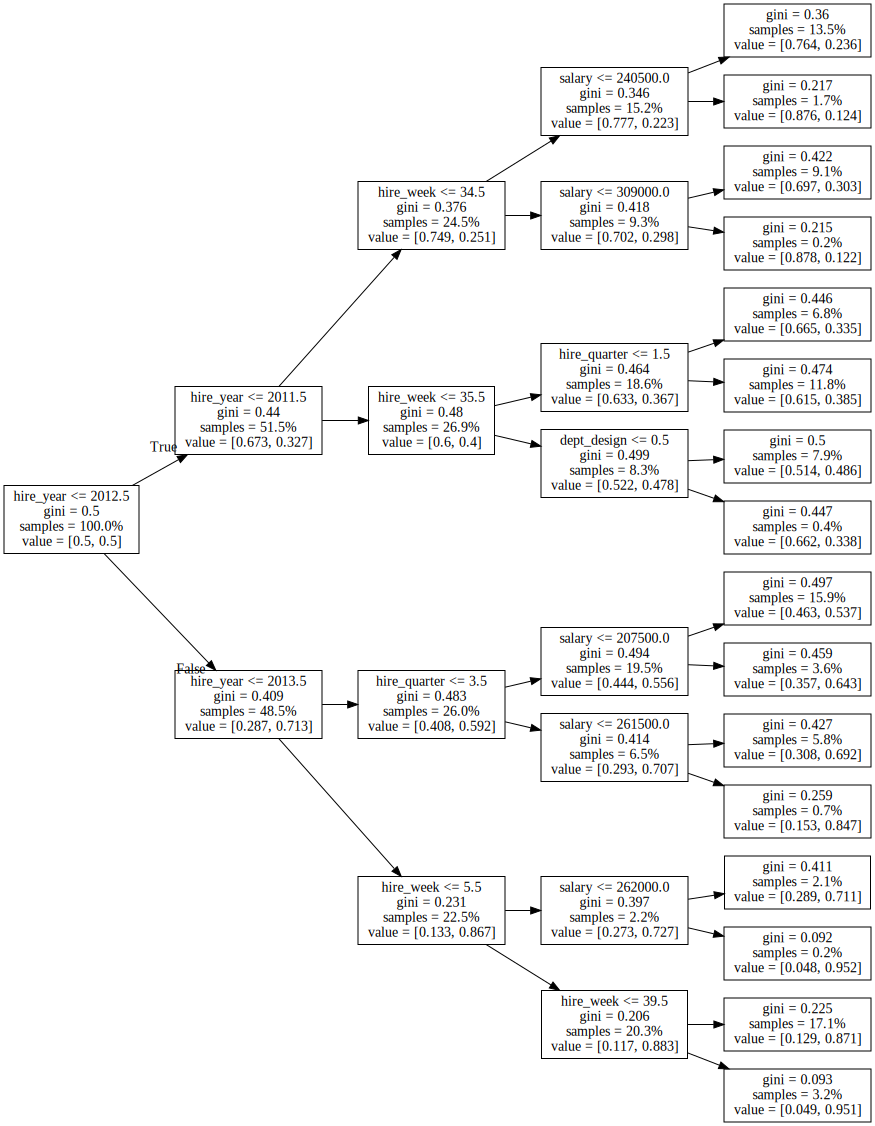

In [42]:
data_dummy = pd.get_dummies(df[['company_id', 'dept', 'seniority', 'hire_year',
                                'hire_quarter', 'hire_week', 'hire_dayofweek',
                                'salary', 'early_quit']], drop_first=True)           
data_dummy = data_dummy.dropna()

model = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, 
                               class_weight="balanced", 
                               min_impurity_decrease = 0.0001)
model.fit(data_dummy.drop('early_quit', axis=1), data_dummy['early_quit'])
  
# Visualize It
export_graphviz(model, out_file="tree_employee.dot", feature_names=data_dummy.drop('early_quit', axis=1).columns, proportion=True, rotate=True)
with open("tree_employee.dot") as f:
    dot_graph = f.read()
tree_source = Source.from_file("tree_employee.dot")
tree_source

In [43]:
data_dummy

,company_id,seniority,hire_year,hire_quarter,hire_week,hire_dayofweek,salary,early_quit,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,7,28,2014,1,13,0,89000.0,0.0,0,0,0,0,0
1,7,20,2013,2,18,0,183000.0,1.0,0,0,0,1,0
2,4,14,2014,4,42,0,101000.0,1.0,0,0,0,1,0
3,7,20,2012,2,20,0,115000.0,1.0,0,0,0,0,0
4,2,23,2011,4,42,0,276000.0,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24695,1,5,2012,2,18,1,172000.0,0.0,1,0,0,0,0
24696,6,7,2012,1,4,3,88000.0,1.0,0,0,0,1,0
24699,4,11,2013,3,36,1,67000.0,0.0,0,0,0,0,0
24700,10,98,2011,4,50,1,266000.0,0.0,0,0,1,0,0


<a name='Adding'></a>
# Adding to the Dataset

The final question we are being asked to consider in this case study is what feature would we add to this dataset to better predict churn. We saw through the data exploration that there were many factors that interact to impact employee retention. To capture the many competing factors in one metric, I would recommend a feature that acts a summary for the job as a whole, either `job satisfaction` or a `net promoter score`.

<a name='Conclusions'></a>
# Conclusions

Looking at the dataset we learn a lot of actionable insights that can be used to impact employee retention.

1. We see a negative trend in employee retention as each year passes. With how costly it is to lose an employee, this should be a high priority and investigated immediately. Did the company cultures or org charts change? Have the companies undergone rapid growth?
2. Looking at the hire date beyond the hire year, we see effects on employee retention by quarter, month, week, and day of week. Based on the cylical nature of business, I believe these trends are due to employees starting in the middle of things. To fix this you can't simply avoid hiring in the third and fourth quarter. Instead, the companies must rework their onboarding process for each department. Onboarding should look to ensure new hires start at the start of new projects or have a gradual increase in workload as they acclimate to the job. Don't throw employees in the deep end on day one. Additionally, implementing a support/mentor program for the first 90 or 180 days to help guide new hires would likely reduce churn as well.
3. We see salary impacts retention as well. Companies should be looking to make sure they are paying employees a competitive rate.
4. Finally, companies should be collecting a lot more data points on their employees and the company as a whole. `Employee Satisfaction` should be the first feature added as it impacts so much. A dissatisfied employee is less productive, cost more to retain, has poorer interpersonal skills, and can spread dissatisfaction to others. Additional features to collect might be `NPS`, `peer ratings`, `department ratings`, `department average employee satisfaction`, `payed at market rate`, etc. The more features you can add, the clearer the picture you'll be able to paint from the data, thus allowing you to address root causes of churn.